In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sp500_constituents_directory = '../data/sp500'
sample_assets = ['AAPL', 'GE', 'IBM', 'KO', 'MSFT']

In [4]:
ff3 = pd.read_csv('../data/F-F_Research_Data_Factors_daily.CSV')
ff3['date'] = pd.to_datetime(ff3['date'], format='%Y%m%d')
ff3['RF'] = ff3['RF'] / 100
ff3['Mkt-RF'] = ff3['Mkt-RF'] / 100
ff3['SMB'] = ff3['SMB'] / 100
ff3['HML'] = ff3['HML'] / 100
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009


In [5]:
df = pd.DataFrame()
for asset in os.listdir(sp500_constituents_directory):
    asset_df = pd.read_csv(f'{sp500_constituents_directory}/{asset}', index_col=0)
    asset_df['date'] = pd.to_datetime(asset_df['date'])
    if (asset_df['close'] == 0).sum() > 0:
        print(asset)
        asset_df['close'].replace(0, np.nan, inplace=True)
        asset_df['close'] = asset_df['close'].ffill()
    asset_df['return'] = asset_df['close'].pct_change()
    asset_df.dropna(subset=['return'], inplace=True)
    asset_df = asset_df[['date', 'symbol', 'series_id', 'close', 'return']]
    asset_df = pd.merge(asset_df, ff3[['date', 'RF', 'Mkt-RF', 'SMB', 'HML']], on='date')
    if len(df) == 0:
        df = asset_df
    else:
        # concat
        df = pd.concat([df, asset_df])
df['return'] = df['return'] - df['RF']
df = df[df['date'] > '2015-01-01']

KR.csv


In [6]:
df['return'].describe()

count    1.230070e+06
mean     4.966915e-04
std      2.099399e-02
min     -8.206364e-01
25%     -8.410386e-03
50%      6.404895e-04
75%      9.546726e-03
max      4.803086e+00
Name: return, dtype: float64

In [7]:
# Print the 10 rows with the highest df['return']
df['return_z_score'] = (df['return'] - df['return'].mean()) / df['return'].std()
print(len(df))
df = df[(df['return_z_score'] <= 3) & (df['return_z_score'] >= -3)]
print(len(df))

1230070
1212112


In [8]:
factors = ['Mkt-RF', 'SMB', 'HML']  # List of factor returns
factor_betas = []

for asset, asset_data in df.groupby('symbol'):
    X = asset_data[factors]  # Use multiple factors
    X = sm.add_constant(X)  # Add intercept
    y = asset_data['return']
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Store betas for each factor along with the expected return
    beta_values = {f'{factor}_loading': results.params[factor] for factor in factors}
    beta_values['symbol'] = asset
    
    factor_betas.append(beta_values)

In [9]:
factor_betas = pd.DataFrame(factor_betas)
factor_betas.head()

,Mkt-RF_loading,SMB_loading,HML_loading,symbol
0,0.982827,0.077516,-0.159084,A
1,1.113392,-0.250614,-0.378536,AAPL
2,0.596637,-0.207678,0.043559,ABBV
3,1.152474,0.520908,-0.294504,ABNB
4,0.785958,-0.263488,-0.181972,ABT


In [10]:
# Sample assets factor sensitivities (Save as .tex)
factor_betas[factor_betas['symbol'].isin(sample_assets)].to_latex(
    '../figs/factor_betas.tex',
    index=False,
    float_format="%.3f",
    column_format='l' + 'c' * len(sample_assets),
    escape=False
)

In [11]:
df = pd.merge(df, factor_betas, on='symbol')
df.head()

,date,symbol,series_id,close,return,RF,Mkt-RF,SMB,HML,return_z_score,Mkt-RF_loading,SMB_loading,HML_loading
0,2015-01-02,CSCO,58375,27.61,-0.007549,0.0,-0.0012,-0.0061,0.0008,-0.383215,0.934331,-0.223223,0.044192
1,2015-01-05,CSCO,58375,27.06,-0.019920,0.0,-0.0184,0.0033,-0.0068,-0.972517,0.934331,-0.223223,0.044192
2,2015-01-06,CSCO,58375,27.05,-0.000370,0.0,-0.0104,-0.0078,-0.0031,-0.041261,0.934331,-0.223223,0.044192
3,2015-01-07,CSCO,58375,27.30,0.009242,0.0,0.0119,0.0020,-0.0066,0.416569,0.934331,-0.223223,0.044192
4,2015-01-08,CSCO,58375,27.51,0.007692,0.0,0.0181,-0.0012,-0.0028,0.342747,0.934331,-0.223223,0.044192


In [12]:
# Dictionary to store the risk premiums (gamma values) for each time period
factor_gammas = {}
factor_loadings = [f"{factor}_loading" for factor in factors]
# Grouping the DataFrame by reporting periods (time periods)
all_periods = df['date'].nunique()
for period, period_group in df.groupby('date'):

    # The dependent variable (returns for the current time period)
    y = period_group['return']
    X = period_group[factor_loadings]
    X = sm.add_constant(X)

    # Fit the Fama-Macbeth regression for this period
    model = sm.OLS(y, X).fit()

    # Store the risk premiums (gamma coefficients) for this period
    params = model.params.to_dict()
    #rename to f'{factor}_premium'
    factor_gammas[period] = {f'{factor}_premium': params[factor] for factor in factor_loadings}

In [13]:
risk_premiums = [f'{factor}_premium' for factor in factor_loadings]
rp_df = pd.DataFrame.from_dict(factor_gammas, orient='index')
expected_factor_returns = rp_df[risk_premiums].mean().to_dict()
expected_factor_cov_matrix = rp_df[risk_premiums].cov()
rp_df.head()

,Mkt-RF_loading_premium,SMB_loading_premium,HML_loading_premium
2015-01-02,-0.004590,-0.002769,0.003082
2015-01-05,-0.023103,0.003397,-0.014870
2015-01-06,-0.026685,-0.000252,-0.001714
2015-01-07,-0.012615,0.009980,-0.005287
2015-01-08,0.013017,0.002839,-0.000968


In [14]:
expected_factor_returns_df = pd.DataFrame.from_dict(expected_factor_returns, orient='index')
expected_factor_returns_df.columns = ['Expected Factor Returns']
expected_factor_returns_df['Expected Factor Returns'] = expected_factor_returns_df['Expected Factor Returns'] * 252
expected_factor_returns_df.index.name = 'Factors'
expected_factor_returns_df.reset_index(inplace=True)
expected_factor_returns_df.to_latex('../figs/expected_factor_returns.tex', index=False, float_format="%.4f")
expected_factor_returns_df.head()

,Factors,Expected Factor Returns
0,Mkt-RF_loading_premium,0.161182
1,SMB_loading_premium,-0.045322
2,HML_loading_premium,-0.096247


<Figure size 1000x600 with 0 Axes>

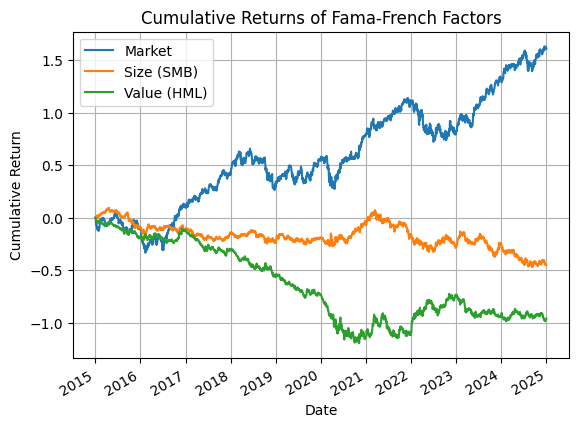

In [15]:
plt.figure(figsize=(10, 6))
rp_df[risk_premiums].cumsum().plot(grid=True)
plt.title('Cumulative Returns of Fama-French Factors')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(['Market', 'Size (SMB)', 'Value (HML)'])

# Save the plot
plt.savefig('../figs/factor_returns.png', dpi=300)

plt.show()

In [16]:
#Annualized expected factor returns
expected_returns = factor_betas.copy()
for factor_rp in risk_premiums:
    expected_returns[factor_rp] = expected_factor_returns[factor_rp] * 252

In [17]:
expected_returns['expected_return'] = expected_returns['Mkt-RF_loading'] * expected_returns['Mkt-RF_loading_premium'] + \
    expected_returns['SMB_loading'] * expected_returns['SMB_loading_premium'] + \
    expected_returns['HML_loading'] * expected_returns['HML_loading_premium']

In [20]:
# expected_returns['expected_return'] = expected_returns['expected_return'] * 252
# save symbol, expected return to a .tex 
expected_returns[['symbol', 'expected_return']].head().to_latex('../figs/apt_expected_returns.tex', float_format="%.2f", index=False)
expected_returns[['symbol', 'expected_return', 'Mkt-RF_loading', 'Mkt-RF_loading_premium',
                  'SMB_loading', 'SMB_loading_premium', 
                  'HML_loading', 'HML_loading_premium']].head()

,symbol,expected_return,Mkt-RF_loading,Mkt-RF_loading_premium,SMB_loading,SMB_loading_premium,HML_loading,HML_loading_premium
0,A,0.170212,0.982827,0.161182,0.077516,-0.045322,-0.159084,-0.096247
1,AAPL,0.227249,1.113392,0.161182,-0.250614,-0.045322,-0.378536,-0.096247
2,ABBV,0.101387,0.596637,0.161182,-0.207678,-0.045322,0.043559,-0.096247
3,ABNB,0.190494,1.152474,0.161182,0.520908,-0.045322,-0.294504,-0.096247
4,ABT,0.156138,0.785958,0.161182,-0.263488,-0.045322,-0.181972,-0.096247


In [21]:
# Factor covariance matrix
factor_cov_matrix = expected_factor_cov_matrix * 252
# save to a .tex
factor_cov_matrix.to_latex('../figs/factor_cov_matrix.tex', index=True, float_format="%.2f")
factor_cov_matrix

,Mkt-RF_loading_premium,SMB_loading_premium,HML_loading_premium
Mkt-RF_loading_premium,0.057794,0.004415,-0.004651
SMB_loading_premium,0.004415,0.021420,0.000573
HML_loading_premium,-0.004651,0.000573,0.023793


In [ ]:
# To note! We do not test for the statistical significance of the factor loadings and risk premiums for the purpose of brevity.